In [1]:
import psfmodels as psfm
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np
import tifffile
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
import pandas as pd
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from scipy.optimize import minimize, LinearConstraint, Bounds, differential_evolution, basinhopping, shgo, dual_annealing, direct
from skimage.filters import gaussian
from scipy.optimize import LinearConstraint
import numpy as np
from copy import deepcopy

def get_midline(arr):
    mid_x = arr.shape[1]//2
    return arr[mid_x]

def get_midline_rotate_method(arr):
    mid_x = arr.shape[1]//2
    midline = np.array([rotate(arr, angle, resize = False, clip = True, preserve_range = True)[mid_x] for angle in range(366)]).mean(axis=0)
    return midline

def MSLE(arr1, arr2): # MEAN SQUARE LOG ERROR
    return np.nanmean((np.log(arr1 + 1) - np.log(arr2 + 1))**2)

def MSE(arr1, arr2):
    return np.nanmean((arr1 - arr2)**2)

def MLSE(arr1, arr2): # MEAN LOG SQUARE ERROR
    return np.nanmean(np.log((arr1 - arr2)**2 + 1))

def RMLSE(arr1, arr2):
    return np.sqrt(MLSE(arr1,arr2))

def RMSLE(arr1, arr2):
    return np.sqrt(MSLE(arr1, arr2))

loss_fns = [MSLE, MSE, MLSE, RMLSE, RMSLE]

def lorentzian_2d_DoG(amplitude, xo, yo, gamma_x, gamma_y, sigma1, sigma2, offset, amplitude_gauss1, amplitude_gauss2, xdata_tuple):
    (x, y) = xdata_tuple
    lorentz =  amplitude / (1 + ((x - xo) / gamma_x)**2 + ((y - yo) / gamma_y)**2) + offset
    gaussian_term_1 = amplitude_gauss1 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma1**2)) + offset * 10
    gaussian_term_2 = amplitude_gauss2 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma2**2))
    DoG = (gaussian_term_1 - gaussian_term_2)
    DoG = DoG - min(0, DoG.min())
    DoG = DoG
    return lorentz * DoG 

def symmetric_moffat_DoG(amplitude, xo, yo, alpha_x, alpha_y, beta, offset, sigma1, sigma2, amplitude_gauss1, amplitude_gauss2, xdata_tuple):
    (x, y) = xdata_tuple
    moffat_term = amplitude * (1 + ((x - xo)**2 / alpha_x**2) + ((y - yo)**2 / alpha_x**2)) ** (-beta)# + offset
    gaussian_term_1 = amplitude_gauss1 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma1**2)) + offset
    gaussian_term_2 = amplitude_gauss2 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma2**2))
    DoG = (gaussian_term_1 - gaussian_term_2)
    DoG = DoG - min(0, DoG.min())
    
    return moffat_term * DoG

def check_zero_cost(intermediate_result):
    if intermediate_result.fun == 0:
        print(f"Cost is zero for parameters: {intermediate_result.x}")
    return False  # return True if you want to stop the optimization here

def perc_err(act,exp):
    return abs((act - exp)/exp) * 100

def get_midline_rotate_method(arr):
    mid_x = arr.shape[1]//2
    midline = np.array([rotate(arr, angle, resize = False, clip = True, preserve_range = True)[mid_x] for angle in range(366)]).mean(axis=0)
    return midline

In [2]:
def fit_moffat(real_PSF, error_function, xdata_tuple):
    param_bounds = {
        'amplitude': (0, 5),
        'xo': (0, real_PSF.shape[1]),
        'yo': (0, real_PSF.shape[0]),
        'alpha_x': (0.001, 50),
        'alpha_y': (0.001, 50),
        'beta': (0.01, 20,),
        'offset': (0, 3),
        'sigma1': (1, 50),
        'sigma2': (1, 50),
        'amplitude_gauss1': (0, 10),
        'amplitude_gauss2': (0, 10),
    }
    
    # Create bounds for optimization
    lower_bounds = [param_bounds[name][0] for name in param_bounds]
    upper_bounds = [param_bounds[name][1] for name in param_bounds]
    bounds = Bounds(lower_bounds, upper_bounds)
    
    
    
    # Define the constraint matrix
    A = np.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1],  # amplitude_gauss2 - amplitude_gauss1  > 0
        [0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0]   # sigma2 - sigma1 > 0 (equivalent to sigma1 < sigma2)
    ])
    
    # Define the lower and upper bounds for the inequalities
    lb = [np.finfo(float).eps, np.finfo(float).eps]  # Lower bounds slightly above 0
    ub = [np.inf, np.inf]                            # Upper bounds are infinity
    
    # Create the LinearConstraint object
    constraints = LinearConstraint(A, lb, ub)


    result = differential_evolution(error_function, bounds, workers = 24, disp = False, callback = check_zero_cost, args = (xdata_tuple, real_PSF))
    return result


In [9]:
def get_real_PSF(PSF_size_xyz):
    pix_mic_conv = 0.05
    real_PSF = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif").astype(np.float32)
    real_PSF = rescale(real_PSF, (0.05/pix_mic_conv, (0.0655/1.5) / pix_mic_conv, (0.0655/1.5) / pix_mic_conv) , anti_aliasing=True)
    #real_PSF = gaussian(real_PSF, sigma = 0.75)
    midpoint_xy = real_PSF.shape[1]//2
    
    original_z = real_PSF.shape[0]
    original_xy = real_PSF.shape[1]
    
    max_intensities = real_PSF.max(axis=(1,2))
    peak_intensity_z =  np.argwhere(max_intensities == np.max(max_intensities))[0][0]
    
    
    real_PSF = real_PSF[
        :, # 23 Z stacks total
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1,
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1
    ]
    
    real_PSF = real_PSF[peak_intensity_z]
    real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
    real_PSF = np.clip(real_PSF, 0, np.inf)
    real_PSF = real_PSF / real_PSF.max()
    return real_PSF

In [4]:
def fit_lorentz(real_PSF, error_function, xdata_tuple):
    param_bounds = {
        'amplitude': (0, 5),
        'xo': (0, real_PSF.shape[1]),
        'yo': (0, real_PSF.shape[0]),
        'gamma_x': (0.001, 50),
        'gamma_y': (0.001, 50),
        'sigma1': (1, 20),
        'sigma2': (1, 20),
        'offset': (0, 3),
        'amplitude_gauss1': (0, 10),
        'amplitude_gauss2': (0, 10),
    }
    
    # Create bounds for optimization
    lower_bounds = [param_bounds[name][0] for name in param_bounds]
    upper_bounds = [param_bounds[name][1] for name in param_bounds]
    bounds = Bounds(lower_bounds, upper_bounds)
    
    
    
    # Define the constraint matrix
    A = np.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 1, -1],  # amplitude_gauss2 - amplitude_gauss1  > 0
        [0, 0, 0, 0, 0, 1, -1, 0, 0, 0]   # sigma2 - sigma1 > 0 (equivalent to sigma1 < sigma2)
    ])
    
    # Define the lower and upper bounds for the inequalities
    lb = [np.finfo(float).eps, np.finfo(float).eps]  # Lower bounds slightly above 0
    ub = [np.inf, np.inf]                            # Upper bounds are infinity

    # Define the constraint matrix
    A = np.array([
        [0, 0, 0, 0, 0, 1, -1, 0, 0, 0]   # sigma2 - sigma1 > 0 (equivalent to sigma1 < sigma2)
    ])
    
    # Define the lower and upper bounds for the inequalities
    lb = [np.finfo(float).eps]  # Lower bounds slightly above 0
    ub = [np.inf]    
    
    # Create the LinearConstraint object
    constraints = LinearConstraint(A, lb, ub)


    result = differential_evolution(error_function, bounds, workers = 24, disp = False, callback = check_zero_cost, args = (xdata_tuple, real_PSF), constraints = constraints, updating='deferred')
    return result


(11, 11)

In [5]:
def fit_to_PSF(PSF_size_xyz, parameterised_function, fit_function, error_function):

    real_PSF = get_real_PSF(PSF_size_xyz)
    x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
    y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
    x, y = xdata_tuple = np.meshgrid(x, y)



    result = fit_function(real_PSF, error_function, xdata_tuple)

    #print(result)
    best_fit = parameterised_function(*result.x, (x,y))
    
    MSE_loss = MSLE(best_fit, real_PSF)

    #plt.plot(best_fit[best_fit.shape[0]//2])
    #plt.plot(get_midline_rotate_method(real_PSF), label = "real")

    #plt.yscale("log")
    #plt.title("Fit")
    #plt.show()
    
    return result, MSE_loss, get_midline_rotate_method(best_fit)

def get_extrapolated_fit(result, original_fit_xy, parameterised_function, error_function):
    real_PSF = get_real_PSF(201)
    x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
    y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
    x, y = xdata_tuple = np.meshgrid(x, y)
    best_fit_result = deepcopy(result.x)
    #best_fit_result[1] = best_fit_result[2] = real_PSF.shape[1]/2
    best_fit_result[2] = best_fit_result[2] + real_PSF.shape[1]/2 - original_fit_xy/2
    best_fit_result[1] = best_fit_result[1] + real_PSF.shape[1]/2 - original_fit_xy/2
    best_fit = parameterised_function(*best_fit_result, (x,y))

    #plt.plot(best_fit[best_fit.shape[0]//2])
    #plt.plot(get_midline_rotate_method(real_PSF), label = "real")
    #plt.plot(real_PSF[real_PSF.shape[0]//2], label = "real")

    #plt.yscale("log")
    #plt.title("Extrapolation")
    #plt.show()
    MSE_loss = MSLE(best_fit, real_PSF)
    return error_function(best_fit_result, xdata_tuple, real_PSF), MSE_loss, get_midline_rotate_method(best_fit), get_midline_rotate_method(real_PSF)

Lowest MSLE = 1.1450752472661426e-05
             message: Optimization terminated successfully.
             success: True
                 fun: 1.7569975923700702e-05
                   x: [ 4.953e+00  2.467e+01  2.443e+01  2.814e+00
                        2.801e+00  1.731e+00  1.566e+00  5.330e-03
                        1.106e+00  9.567e-01]
                 nit: 614
                nfev: 79641
          population: [[ 3.506e+00  2.466e+01 ...  5.289e-01  3.051e-01]
                       [ 3.475e+00  2.467e+01 ...  4.960e-01  2.616e-01]
                       ...
                       [ 3.350e+00  2.466e+01 ...  5.150e-01  2.834e-01]
                       [ 3.378e+00  2.467e+01 ...  5.248e-01  2.987e-01]]
 population_energies: [ 1.757e-05  1.847e-05 ...  1.849e-05  1.847e-05]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0
                 jac: [array([[ 0.000e+00,  0.000e+00,  0.000e+00,
                               0.000e+00, 

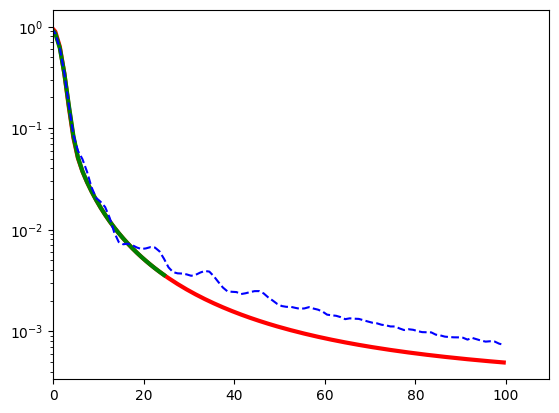

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Lowest MSLE = 1.1178861228816329e-05
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9790753908621975e-05
                   x: [ 3.676e+00  2.466e+01  2.442e+01  3.187e+00
                        3.248e+00  1.827e+00  1.503e+00  5.697e-03
                        6.993e-01  4.796e-01]
                 nit: 566
                nfev: 89998
          population: [[ 3.676e+00  2.466e+01 ...  6.993e-01  4.796e-01]
                       [ 3.273e+00  2.467e+01 ...  8.035e-01  5.694e-01]
                       ...
                       [ 3.749e+00  2.466e+01 ...  6.675e-01  4.474e-01]
                       [ 3.493e+00  2.467e+01 ...  7.547e-01  5.271e-01]]
 population_energies: [ 1.979e-05  2.066e-05 ...  1.989e-05  2.005e-05]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0


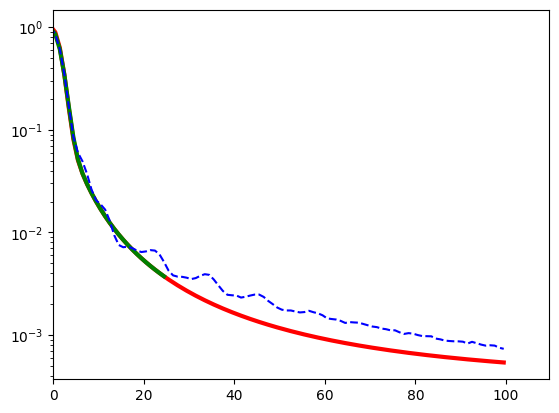

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Lowest MSLE = 1.1164670690473464e-05
             message: Optimization terminated successfully.
             success: True
                 fun: 2.1164095692592924e-05
                   x: [ 2.207e+00  2.467e+01  2.441e+01  3.893e+00
                        3.846e+00  1.970e+00  1.326e+00  6.674e-03
                        6.375e-01  2.458e-01]
                 nit: 439
                nfev: 71336
          population: [[ 2.207e+00  2.467e+01 ...  6.375e-01  2.458e-01]
                       [ 2.253e+00  2.467e+01 ...  5.856e-01  2.044e-01]
                       ...
                       [ 2.213e+00  2.468e+01 ...  6.234e-01  2.367e-01]
                       [ 2.236e+00  2.466e+01 ...  5.738e-01  1.852e-01]]
 population_energies: [ 2.116e-05  2.148e-05 ...  2.133e-05  2.145e-05]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0


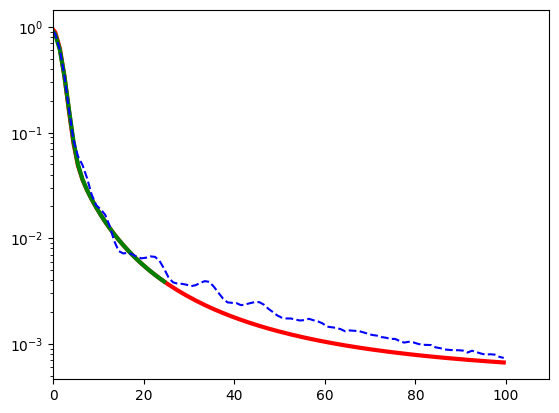

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Lowest MSLE = 1.1078093096576476e-05
             message: Optimization terminated successfully.
             success: True
                 fun: 0.004703564918498874
                   x: [ 1.665e+00  2.466e+01  2.442e+01  3.996e+00
                        4.069e+00  1.923e+00  1.378e+00  8.204e-03
                        9.024e-01  3.746e-01]
                 nit: 416
                nfev: 65387
          population: [[ 1.665e+00  2.466e+01 ...  9.024e-01  3.746e-01]
                       [ 1.616e+00  2.466e+01 ...  8.856e-01  3.555e-01]
                       ...
                       [ 1.375e+00  2.467e+01 ...  8.542e-01  2.002e-01]
                       [ 1.691e+00  2.466e+01 ...  8.928e-01  3.747e-01]]
 population_energies: [ 4.704e-03  4.727e-03 ...  4.856e-03  4.811e-03]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0


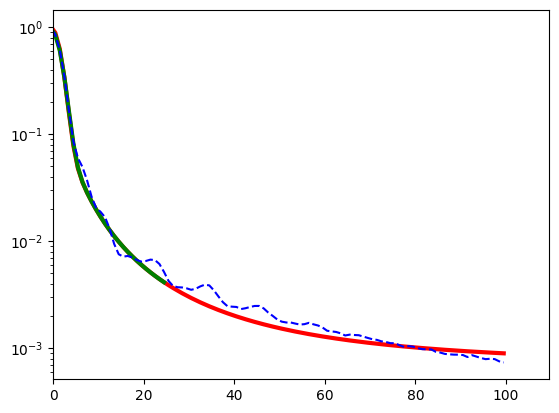

Lowest MSLE = 1.0979256109318163e-05
             message: Optimization terminated successfully.
             success: True
                 fun: 0.004923740851700243
                   x: [ 1.113e+00  2.466e+01  2.440e+01  4.297e+00
                        4.228e+00  1.824e+00  1.567e+00  1.057e-02
                        2.248e+00  1.447e+00]
                 nit: 408
                nfev: 62899
          population: [[ 1.113e+00  2.466e+01 ...  2.248e+00  1.447e+00]
                       [ 1.074e+00  2.468e+01 ...  2.430e+00  1.574e+00]
                       ...
                       [ 1.102e+00  2.468e+01 ...  2.373e+00  1.556e+00]
                       [ 1.025e+00  2.467e+01 ...  2.388e+00  1.505e+00]]
 population_energies: [ 4.924e-03  5.159e-03 ...  4.968e-03  4.973e-03]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0


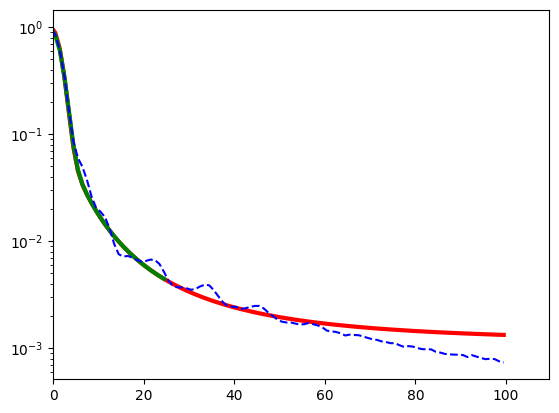

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Lowest MSLE = 1.0915649451785609e-05
             message: Optimization terminated successfully.
             success: True
                 fun: 2.042527207799461e-05
                   x: [ 2.622e+00  2.466e+01  2.441e+01  3.407e+00
                        3.422e+00  1.896e+00  1.421e+00  7.009e-03
                        7.095e-01  3.949e-01]
                 nit: 612
                nfev: 87970
          population: [[ 2.622e+00  2.466e+01 ...  7.095e-01  3.949e-01]
                       [ 2.580e+00  2.466e+01 ...  7.013e-01  3.851e-01]
                       ...
                       [ 2.583e+00  2.467e+01 ...  7.334e-01  4.198e-01]
                       [ 2.591e+00  2.466e+01 ...  7.843e-01  4.723e-01]]
 population_energies: [ 2.043e-05  2.049e-05 ...  2.077e-05  2.060e-05]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0


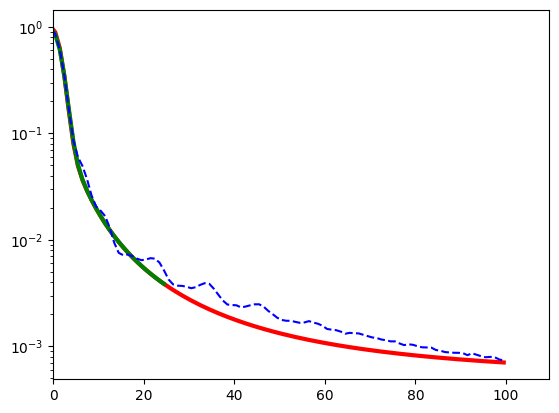

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Lowest MSLE = 1.0866702436698045e-05
             message: Optimization terminated successfully.
             success: True
                 fun: 0.004568484588671332
                   x: [ 2.569e+00  2.466e+01  2.441e+01  3.123e+00
                        3.105e+00  1.960e+00  1.352e+00  8.253e-03
                        6.421e-01  3.324e-01]
                 nit: 425
                nfev: 63653
          population: [[ 2.569e+00  2.466e+01 ...  6.421e-01  3.324e-01]
                       [ 2.593e+00  2.466e+01 ...  6.637e-01  3.633e-01]
                       ...
                       [ 2.715e+00  2.465e+01 ...  5.847e-01  2.963e-01]
                       [ 2.568e+00  2.466e+01 ...  7.043e-01  3.944e-01]]
 population_energies: [ 4.568e-03  4.602e-03 ...  4.664e-03  4.595e-03]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0


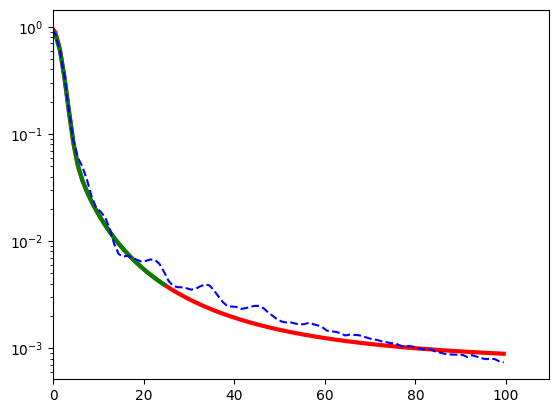

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better resu

Lowest MSLE = 1.0625159311350906e-05
             message: Optimization terminated successfully.
             success: True
                 fun: 0.004874864903888249
                   x: [ 1.195e+00  2.465e+01  2.441e+01  4.359e+00
                        4.374e+00  1.972e+00  1.287e+00  1.000e-02
                        1.083e+00  3.395e-01]
                 nit: 384
                nfev: 61830
          population: [[ 1.195e+00  2.465e+01 ...  1.083e+00  3.395e-01]
                       [ 1.115e+00  2.467e+01 ...  1.028e+00  2.123e-01]
                       ...
                       [ 1.045e+00  2.466e+01 ...  1.223e+00  3.704e-01]
                       [ 1.209e+00  2.467e+01 ...  9.778e-01  2.522e-01]]
 population_energies: [ 4.875e-03  4.914e-03 ...  4.936e-03  4.913e-03]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0


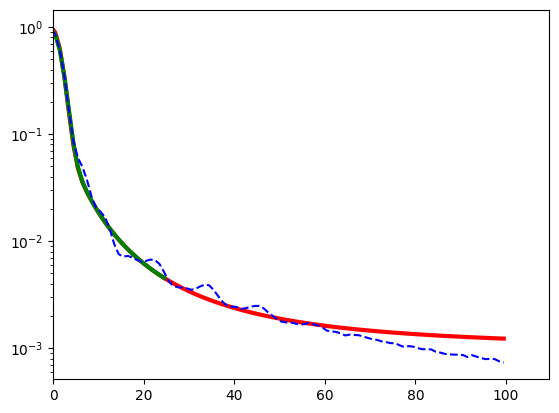

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better resu

Lowest MSLE = 1.0534314175356835e-05
             message: Optimization terminated successfully.
             success: True
                 fun: 0.0046776527606576255
                   x: [ 1.865e+00  2.465e+01  2.441e+01  3.719e+00
                        3.711e+00  2.005e+00  1.298e+00  8.281e-03
                        7.311e-01  2.726e-01]
                 nit: 429
                nfev: 67687
          population: [[ 1.865e+00  2.465e+01 ...  7.311e-01  2.726e-01]
                       [ 1.847e+00  2.464e+01 ...  7.036e-01  2.322e-01]
                       ...
                       [ 1.869e+00  2.467e+01 ...  7.448e-01  2.906e-01]
                       [ 1.701e+00  2.466e+01 ...  7.873e-01  2.782e-01]]
 population_energies: [ 4.678e-03  4.719e-03 ...  4.716e-03  4.711e-03]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0


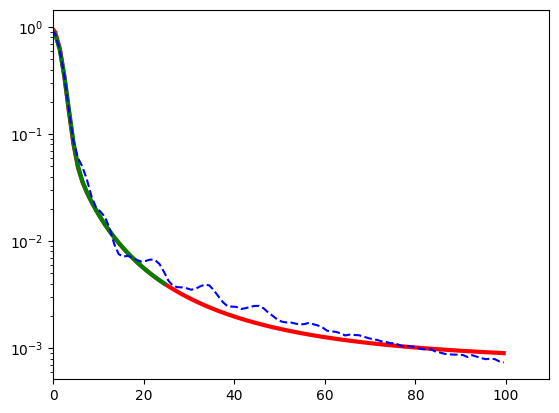

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better resu

In [6]:
results = []
lowest_MSE_loss = 10
while True:
    for loss_fn in loss_fns:
    
        def error_function(params, *args):
            synthetic = lorentzian_2d_DoG(*params, args[0])
            return loss_fn(synthetic, args[1])
    
        #print(loss_fn)
        small_fit_size = 50
        result, MSE_loss_50px, fit_midline = fit_to_PSF(small_fit_size, lorentzian_2d_DoG, fit_lorentz, error_function)
        #print(f"50px fit = {MSE_loss_50px}")
        extrapolated_fit, MSE_loss_extrapolated, extrapolated_midline, real_PSF_midline = get_extrapolated_fit(result, small_fit_size, lorentzian_2d_DoG, error_function)
        #print(f"Extrapolated fit = {MSE_loss_extrapolated}")
        
        results.append([result, MSE_loss_extrapolated])
        if MSE_loss_extrapolated < lowest_MSE_loss:
            print(f"Lowest MSLE = {MSE_loss_extrapolated}")
            print(result)
            lowest_MSE_loss = MSE_loss_extrapolated

    
            extrapolated_x = np.arange(-201/2, 201/2)
            fit_x = np.arange(-len(fit_midline)/2, len(fit_midline)/2)
        
            
            plt.plot(extrapolated_x, extrapolated_midline, c = "red", linewidth = 3)
            plt.plot(fit_x, fit_midline, c = "green", linewidth = 3)
            plt.plot(extrapolated_x, real_PSF_midline,  c = "blue", linestyle = "--")
            plt.yscale("log")
            #plt.xscale("log")
            plt.xlim(0,)
            plt.show()

        #result_full_fit, MSE_loss_201px = fit_to_PSF(201, lorentzian_2d_DoG, fit_lorentz, error_function)
        #print(f"201px fit = {MSE_loss_201px}")
        #print(f"Percentage difference = {perc_err(MSE_loss_extrapolated,MSE_loss_201px)}")
